In [44]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot

from pandas_profiling import ProfileReport

In [45]:
WORKDIR = os.getcwd()
DATADIR = os.path.join(WORKDIR, '../data')

In [80]:
# Read in all csv files
df_weather = pd.read_csv(os.path.join(DATADIR, 'weather.csv'), parse_dates = ['data_index_'], index_col = 'data_index_')
df_load = pd.read_csv(os.path.join(DATADIR, 'load_actuals.csv'), parse_dates = ['data_index_'], index_col = 'data_index_')
df_wind = pd.read_csv(os.path.join(DATADIR, 'wind_solar_predictions.csv'), parse_dates = ['data_index_'], index_col = 'data_index_')

In [81]:
df_load.head()

,load_actuals_mw
data_index_,
2020-01-01 00:00:00+00:00,95.756328
2020-01-01 00:15:00+00:00,94.836196
2020-01-01 00:30:00+00:00,93.798127
2020-01-01 00:45:00+00:00,92.162902
2020-01-01 01:00:00+00:00,91.506670


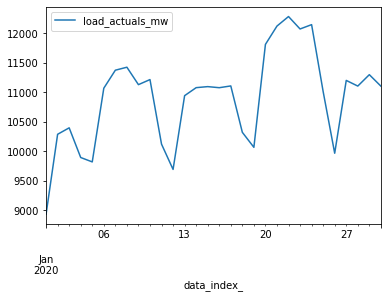

In [82]:
# Get daily load_actuals instead of every 15min in a day
df_load.resample('D').sum().head(30).plot()
df_load_daily = df_load.resample('D').sum()

In [83]:
# Creating new column day of week from 0 to 6 from Sunday to Saturday
df_load_daily['dayofweek'] = df_load_daily.index.weekday

In [84]:
df_load_daily.head()

,load_actuals_mw,dayofweek
data_index_,,
2020-01-01 00:00:00+00:00,8931.046100,2
2020-01-02 00:00:00+00:00,10287.299968,3
2020-01-03 00:00:00+00:00,10396.662102,4
2020-01-04 00:00:00+00:00,9893.106810,5
2020-01-05 00:00:00+00:00,9818.553867,6


In [85]:
#df_load.assign(weekday = df_load.index.weekday)

In [86]:
df_load_pred = (
    df_load_daily.groupby('dayofweek')
    .rolling(2, closed = 'left')
    .mean()
    .reset_index()
    .sort_values(by ='data_index_')
    .set_index('data_index_')
).rename(columns ={'load_actuals_mw' : 'load_pred_mw'})

In [87]:
df_load_pred.head(20)

,dayofweek,load_pred_mw
data_index_,,
2020-01-01 00:00:00+00:00,2,NaN
2020-01-02 00:00:00+00:00,3,NaN
2020-01-03 00:00:00+00:00,4,NaN
2020-01-04 00:00:00+00:00,5,NaN
2020-01-05 00:00:00+00:00,6,NaN
2020-01-06 00:00:00+00:00,0,NaN
2020-01-07 00:00:00+00:00,1,NaN
2020-01-08 00:00:00+00:00,2,NaN
2020-01-09 00:00:00+00:00,3,NaN


<AxesSubplot:xlabel='data_index_'>

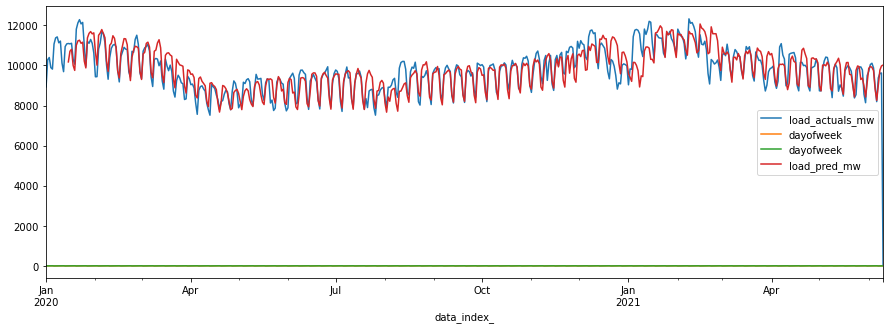

In [88]:
fig, ax = pyplot.subplots(figsize = [15, 5])
df_load_daily.plot( ax = ax)
df_load_pred.plot(ax = ax)

In [89]:
MAPE = abs((df_load_pred.load_pred_mw - df_load_daily.load_actuals_mw)/df_load_daily.load_actuals_mw).sum()/len(df_load_pred) * 100
MAPE

26.520473692265178

In [90]:
def generate_rolling(df, var, max_roll):
    for t in range(1, max_roll+1):
        df['load_pred_roll'+str(t)] = (
            df.groupby(var)
            .rolling(t, closed = 'left')
            .mean()
            .reset_index()
            .sort_values(by ='data_index_')
            .set_index('data_index_')
        )['load_actuals_mw']

In [91]:
generate_rolling(df_load_daily, 'dayofweek', 6)

In [92]:
df_load_daily.head(30)

,load_actuals_mw,dayofweek,load_pred_roll1,load_pred_roll2,load_pred_roll3,load_pred_roll4,load_pred_roll5,load_pred_roll6
data_index_,,,,,,,,
2020-01-01 00:00:00+00:00,8931.046100,2,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 00:00:00+00:00,10287.299968,3,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03 00:00:00+00:00,10396.662102,4,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04 00:00:00+00:00,9893.106810,5,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05 00:00:00+00:00,9818.553867,6,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06 00:00:00+00:00,11069.136081,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07 00:00:00+00:00,11374.718430,1,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08 00:00:00+00:00,11425.253712,2,8931.046100,NaN,NaN,NaN,NaN,NaN
2020-01-09 00:00:00+00:00,11129.585824,3,10287.299968,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='data_index_'>

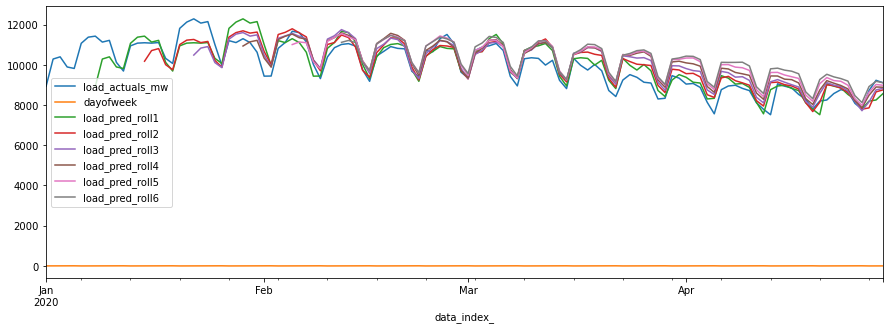

In [93]:
fig, ax = pyplot.subplots(figsize = [15, 5])
df_load_daily.head(120).plot( ax = ax)


In [ ]:
MAPE = abs((df_load_pred.load_pred_mw - df_load_daily.load_actuals_mw)/df_load_daily.load_actuals_mw).sum()/len(df_load_pred) * 100
MAPE

In [ ]:
#df_weather.info()
#df_load.info()
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50497 entries, 2020-01-01 00:00:00+00:00 to 2021-06-10 00:00:00+00:00
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   solar_prediction_mw  50497 non-null  float64
 1   wind_prediction_mw   50497 non-null  float64
dtypes: float64(2)
memory usage: 1.2 MB


In [ ]:
min1 = df_weather.index.min()

In [ ]:
max1 = df_weather.index.max()

In [ ]:
date = pd.date_range(min1, max1, freq='15T')

In [ ]:
date.shape

(50497,)

In [ ]:
date = pd.DataFrame(index = date)

In [ ]:
date.head()

""
2020-01-01 00:00:00+00:00
2020-01-01 00:15:00+00:00
2020-01-01 00:30:00+00:00
2020-01-01 00:45:00+00:00
2020-01-01 01:00:00+00:00


In [ ]:
df = pd.merge(df_wind, date, how = 'right', right_index = True, left_index = True)

In [ ]:
df.head()

,solar_prediction_mw,wind_prediction_mw
2020-01-01 00:00:00+00:00,0.0,70.865426
2020-01-01 00:15:00+00:00,0.0,69.296785
2020-01-01 00:30:00+00:00,0.0,66.977409
2020-01-01 00:45:00+00:00,0.0,64.305715
2020-01-01 01:00:00+00:00,0.0,61.128262


In [ ]:
df = pd.merge(df_weather, df, how = 'right', right_index = True, left_index = True)

NameError: name 'df' is not defined

In [ ]:
df = pd.merge(df_load, df, how = 'right', right_index = True, left_index = True)

NameError: name 'df' is not defined

In [61]:
df.head()

NameError: name 'df' is not defined

In [62]:
df.to_csv(os.path.join(DATADIR, 'input_data.csv'), index_label='date')

NameError: name 'df' is not defined

In [139]:
df = pd.read_csv(os.path.join(DATADIR,'input_data.csv'), parse_dates = ['date'])

In [140]:
df.head()

,date,load_actuals_mw,temperature,solar_ghi,solar_prediction_mw,wind_prediction_mw
0,2020-01-01 00:00:00+00:00,95.756328,274.989655,0.0,0.0,70.865426
1,2020-01-01 00:15:00+00:00,94.836196,274.925659,0.0,0.0,69.296785
2,2020-01-01 00:30:00+00:00,93.798127,274.861694,0.0,0.0,66.977409
3,2020-01-01 00:45:00+00:00,92.162902,274.797699,0.0,0.0,64.305715
4,2020-01-01 01:00:00+00:00,91.506670,274.423157,0.0,0.0,61.128262


In [141]:
profile = df.profile_report(
    title="Pandas Profiling Report")

profile.to_file("output.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 111.11it/s]
